In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Functions to print the images
def myImPrt(img):
    tmp_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(tmp_img)

def myBWImPrt(img):
    plt.imshow(img,cmap='gray')

In [3]:
# ref #https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
def bilateralFilter(image, d, sig):
    image = cv2.bilateralFilter(image, d, sig, sig)
    return image

def threshold(image, t):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, image = cv2.threshold(image, t, 255, cv2.THRESH_BINARY_INV)
#     ret, image = cv2.threshold(image, t, 255, cv2.THRESH_BINARY)
    return image

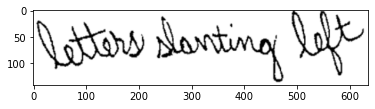

In [4]:
image = cv2.imread('images/Capture.PNG')
# cv2.imshow('image',image)
myImPrt(image)

In [5]:
TOP_MARGIN = 0.0
LETTER_SIZE = 0.00001
LINE_SPACING = 0.0
WORD_SPACING = 0.0


In [6]:
#function to calculate horizontal projection of the image pixel rows and return it 
def horizontalProjection(img):
    # Return a list containing the sum of the pixels in each row
    (h, w) = img.shape[:2]
    sumRows = []
    for j in range(h):
        row = img[j:j+1, 0:w] # y1:y2, x1:x2
        sumRows.append(np.sum(row))
    return sumRows

In [7]:
''' function to calculate vertical projection of the image pixel columns and return it '''
def verticalProjection(img):
    # Return a list containing the sum of the pixels in each column
    (h, w) = img.shape[:2]
    sumCols = []
    for j in range(w):
        col = img[0:h, j:j+1] # y1:y2, x1:x2
        sumCols.append(np.sum(col))
    return sumCols

In [8]:
img = image.copy()

In [9]:
filtered = bilateralFilter(img, 5, 50)

thresh = threshold(filtered, 127)

# extract a python list containing values of the horizontal projection of the image into 'hp'
hpList = horizontalProjection(thresh)

# Extracting 'Top Margin' feature.
topMarginCount = 0
for sum in hpList:
    # sum can be strictly 0 as well.
    if(sum<=255):
        topMarginCount += 1
    else:
        break


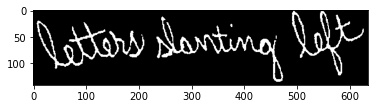

In [10]:
plt.imshow(thresh,cmap='gray')

In [11]:
lineTop = 0
lineBottom = 0
spaceTop = 0
spaceBottom = 0
setLineTop = True
setSpaceTop = True
includeNextSpace = True
space_zero = [] # stores the amount of space between lines
lines = [] # a 2D list storing the vertical start index and end index of each contour

In [12]:
# FIRST we extract the straightened contours from the image by looking at occurance of 0's in the horizontal projection.
# we are scanning the whole horizontal projection now 
for i, sum in enumerate(hpList):
    # sum being 0 means blank space
    if(sum<3000):
        if(setSpaceTop):
            spaceTop = i;
            setSpaceTop = False # spaceTop will be set once for each start of a space between lines
        spaceBottom = i+1;
       
        if(i<len(hpList)-1): # this condition is necessary to avoid array index out of bound error
            if(hpList[i+1]<3000): # if the next horizontal projectin is 0, keep on counting, it's still in blank space
                continue
        # we are using this condition if the previous contour is very thin and possibly not a line
        if(includeNextSpace):
            space_zero.append(spaceBottom-spaceTop)
        else:
            if (len(space_zero)==0):
                previous = 0
            else:
                previous = space_zero.pop()
            space_zero.append(previous + spaceBottom-lineTop)
        setSpaceTop = True # next time we encounter 0, it's begining of another space so we set new spaceTop

    # sum greater than 0 means contour
    if(sum>3000):
        if(setLineTop):
            lineTop = i
            setLineTop = False # lineTop will be set once for each start of a new line/contour
        lineBottom = i+1

        if(i<len(hpList)-1): # this condition is necessary to avoid array index out of bound error
            if(hpList[i+1]>3000): # if the next horizontal projectin is > 0, keep on counting, it's still in contour
                continue

            # if the line/contour is too thin <10 pixels (arbitrary) in height, we ignore it.
            # Also, we add the space following this and this contour itself to the previous space to form a bigger space: spaceBottom-lineTop.
            if(lineBottom-lineTop<20):
                includeNextSpace = False
                setLineTop = True # next time we encounter value > 0, it's begining of another line/contour so we set new lineTop
                continue
        includeNextSpace = True # the line/contour is accepted, new space following it will be accepted

        # append the top and bottom horizontal indices of the line/contour in 'lines'
        lines.append([lineTop, lineBottom])
        setLineTop = True # next time we encounter value > 0, it's begining of another line/contour so we set new lineTop


In [13]:

# Printing the values we found so far.
for i, line in enumerate(lines):
    print()
    print (i)
    print (line[0])
    print (line[1])
    print (len(hpList[line[0]:line[1]]))
    print (hpList[line[0]:line[1]])




0
4
123
119
[3570, 4335, 4845, 5100, 5100, 5100, 4845, 4590, 4590, 5100, 5610, 6375, 6885, 7650, 7905, 6120, 6375, 7650, 8160, 9945, 10965, 11475, 11730, 13005, 12495, 14025, 13515, 13005, 11985, 12750, 12750, 13005, 12750, 12750, 13005, 15300, 16830, 17085, 18360, 18870, 21420, 22185, 29325, 30600, 32130, 28560, 31620, 33660, 32385, 39270, 40800, 44625, 46410, 49215, 46920, 41310, 37485, 34935, 33405, 35190, 36975, 38760, 39780, 39780, 37485, 40035, 43350, 41820, 44625, 43605, 44625, 44625, 44370, 43350, 42330, 36465, 36465, 33660, 28815, 33150, 33660, 30855, 25755, 23970, 20145, 12750, 10710, 9690, 8670, 7650, 7905, 8160, 8160, 8670, 8670, 11730, 14535, 14025, 14280, 12750, 9945, 5355, 5100, 4845, 5100, 4590, 3825, 3315, 3315, 3315, 3315, 3315, 4080, 3825, 4080, 3570, 3060, 3315, 3060]


In [14]:
# for i, line in enumerate(lines):
#     cv2.imshow("line "+str(i), img[line[0]:line[1], : ])
# cv2.waitKey(0)

In [15]:
# LINE SPACING and LETTER SIZE will be extracted here
# We will count the total number of pixel rows containing upper and lower zones of the lines 
# and add the space_zero/runs of 0's(excluding first and last of the list ) to it.
# We will count the total number of pixel rows containing midzones of the lines for letter size.
# For this, we set an arbitrary (yet suitable!) threshold THRESHOLD = 15000 in 
# horizontal projection to identify the midzone containing rows.
# These two total numbers will be divided by number of lines (having at least one row>THRESHOLD) 
# to find average line spacing and average letter size.
THRESHOLD = 15000
new_space_row_count = 0
total_row_count = 0
total_lines_count = 0
flag = False
for i, line in enumerate(lines):
    segment = hpList[line[0]:line[1]]
    for j, sum in enumerate(segment):
        if(sum<THRESHOLD):
            new_space_row_count += 1
        else:
            total_row_count += 1
            flag = True

    # This line has contributed at least one count of pixel row of midzone
    if(flag):
        total_lines_count += 1
        flag = False

In [16]:
# error prevention
if(total_lines_count == 0): total_lines_count = 1

total_space_row_count = new_space_row_count + np.sum(space_zero[1:-1]) #excluding first and last entries: Top and Bottom margins
# the number of spaces is 1 less than number of lines but total_space_row_count contains the top and bottom spaces of the line
average_line_spacing = float(total_space_row_count) / total_lines_count 
average_letter_size = float(total_row_count) / total_lines_count
# letter size is actually height of the letter and we are not considering width
LETTER_SIZE = average_letter_size
# error prevention 
if(average_letter_size == 0): average_letter_size = 1
# We can't just take the average_line_spacing as a feature directly. We must take the average_line_spacing relative to average_letter_size.
# Let's take the ratio of average_line_spacing to average_letter_size as the LINE SPACING, which is perspective to average_letter_size.
relative_line_spacing = average_line_spacing / average_letter_size
LINE_SPACING = relative_line_spacing

# Top marging is also taken relative to average letter size of the handwritting
# relative_top_margin = float(topMarginCount) / average_letter_size
# TOP_MARGIN = relative_top_margin


In [17]:
print(space_zero)
print(lines)
print(total_row_count)
print(total_space_row_count)
print(len(hpList))
print(total_lines_count)
print(i)
print("Average Line Spacing: "+ str(average_line_spacing))
print ("Average letter size: "+ str(average_letter_size))
# print ("Top margin relative to average letter size: "+str(relative_top_margin))
print("Average line spacing relative to \naverage letter size: "+str(relative_line_spacing)) 


[4, 18]
[[4, 123]]
50
69.0
141
1
0
Average Line Spacing: 69.0
Average letter size: 50.0
Average line spacing relative to 
average letter size: 1.38


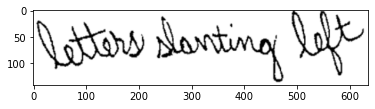

In [18]:
myImPrt(image)

In [19]:
# Extraction of words from the lines using vertical projection
# Width of the whole document is found once.
width = thresh.shape[1]
space_zero = [] # stores the amount of space between words
words = [] # a 2D list storing the coordinates of each word: y1, y2, x1, x2

In [20]:
# Isolated words or components will be extacted from each line by looking at occurance of 0's in its vertical projection.
for i, line in enumerate(lines):
    extract = thresh[line[0]:line[1], 0:width] # y1:y2, x1:x2
    vp = verticalProjection(extract)
    wordStart = 0
    wordEnd = 0
    spaceStart = 0
    spaceEnd = 0
    setWordStart = True
    setSpaceStart = True
    includeNextSpace = False
    
#     spaces = []

    # we are scanning the vertical projection
    for j, sum in enumerate(vp):
        # sum being 0 means blank space
        if(sum==0):
            if(setSpaceStart):
                spaceStart = j
                setSpaceStart = False # spaceStart will be set once for each start of a space between lines
            spaceEnd = j+1
            if(j<len(vp)-1): # this condition is necessary to avoid array index out of bound error
                if(vp[j+1]==0): # if the next vertical projectin is 0, keep on counting, it's still in blank space
                    continue

            # we ignore spaces which is smaller than half the average letter size
            if((spaceEnd-spaceStart) > int(LETTER_SIZE/2)):
                space_zero.append(spaceEnd-spaceStart)
            else:
                includeNextSpace=True  
                
            setSpaceStart = True # next time we encounter 0, it's begining of another space so we set new spaceStart

        # sum greater than 0 means word
        if(sum>0):
            if(setWordStart):
                wordStart = j
                setWordStart = False # wordStart will be set once for each start of a new word/component
            wordEnd = j+1
            if(j<len(vp)-1): # this condition is necessary to avoid array index out of bound error
                if(vp[j+1]>0): # if the next horizontal projectin is > 0, keep on counting, it's still in non-space zone
                    continue

            # append the coordinates of each word/component: y1, y2, x1, x2 in 'words'
            # we ignore the ones which has height smaller than half the average letter size
            # this will remove full stops and commas as an individual component
            count = 0
            for k in range(line[1]-line[0]):
                row = thresh[line[0]+k:line[0]+k+1, wordStart:wordEnd] # y1:y2, x1:x2
                if(np.sum(row)):
                    count += 1
                #U.S.A. special case not handelled
            if(count > int(LETTER_SIZE/2)):
                if(includeNextSpace):
                    includeNextSpace = False
                    if(len(words)!=0):
                        words[len(words)-1][3] = wordEnd
                else:
                    words.append([line[0], line[1], wordStart, wordEnd])

            setWordStart = True # next time we encounter value > 0, it's begining of another word/component so we set new wordStart

#     space_zero.extend(spaces[1:-1])


In [21]:
# # cv2.imshow("word "+str(i), thresh[words[0][0]:words[0][1], words[0][2]:words[0][3]])
# # print("Words count is: ")
# # print(len(words))
# word = words[15]
# myBWImPrt(image[word[0]:word[1], word[2]:word[3]])
# # myBWImPrt(thresh)


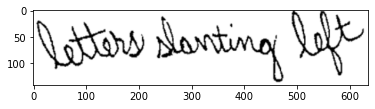

In [22]:
myImPrt(image)

In [23]:
#print space_zero
space_columns = np.sum(space_zero)
space_count = len(space_zero)
if(space_count == 0):
    space_count = 1
average_word_spacing = float(space_columns) / space_count
relative_word_spacing = average_word_spacing / LETTER_SIZE
WORD_SPACING = relative_word_spacing
#print "Average word spacing: "+str(average_word_spacing)
print ("Average word spacing relative to average letter size: "+str(relative_word_spacing))

Average word spacing relative to average letter size: 0.0


In [24]:
###Slant
img = image.copy()

In [25]:
# def extractSlant(img, words):

SLANT_ANGLE = 0.0
'''
0.01 radian = 0.5729578 degree :: I had to put this instead of 0.0 becuase there was a bug yeilding inacurate value which I could not figure out!
5 degree = 0.0872665 radian :: Hardly noticeable or a very little slant
15 degree = 0.261799 radian :: Easily noticeable or average slant
30 degree = 0.523599 radian :: Above average slant
45 degree = 0.785398 radian :: Extreme slant
'''
# We are checking for 9 different values of angle
theta = [-0.785398, -0.523599, -0.261799, -0.0872665, 0.01, 0.0872665, 0.261799, 0.523599, 0.785398]
#theta = [-0.785398, -0.523599, -0.436332, -0.349066, -0.261799, -0.174533, -0.0872665, 0, 0.0872665, 0.174533, 0.261799, 0.349066, 0.436332, 0.523599, 0.785398]

# Corresponding index of the biggest value in s_function will be the index of the most likely angle in 'theta'
s_function = [0.0] * 9
count_ = [0]*9

# apply bilateral filter
filtered = bilateralFilter(img, 5, 50)

# convert to grayscale and binarize the image by INVERTED binary thresholding
# it's better to clear unwanted dark areas at the document left edge and use a high threshold value to preserve more text pixels
thresh = threshold(filtered, 180)
#cv2.imshow('thresh', lthresh)

# loop for each value of angle in theta
for i, angle in enumerate(theta):
    s_temp = 0.0 # overall sum of the functions of all the columns of all the words!
    count = 0 # just counting the number of columns considered to contain a vertical stroke and thus contributing to s_temp

    #loop for each word
    for j, word in enumerate(words):
        original = thresh[word[0]:word[1], word[2]:word[3]] # y1:y2, x1:x2

        height = word[1]-word[0]
        width = word[3]-word[2]

        # the distance in pixel we will shift for affine transformation
        # it's divided by 2 because the uppermost point and the lowermost points are being equally shifted in opposite directions
        shift = (math.tan(angle) * height) / 2

        # the amount of extra space we need to add to the original image to preserve information
        # yes, this is adding more number of columns but the effect of this will be negligible
        pad_length = abs(int(shift))

        # create a new image that can perfectly hold the transformed and thus widened image
        blank_image = np.zeros((height,width+pad_length*2,3), np.uint8)
        new_image = cv2.cvtColor(blank_image, cv2.COLOR_BGR2GRAY)
        new_image[:, pad_length:width+pad_length] = original

        # points to consider for affine transformation
        (height, width) = new_image.shape[:2]
        x1 = width/2
        y1 = 0
        x2 = width/4
        y2 = height
        x3 = 3*width/4
        y3 = height

        pts1 = np.float32([[x1,y1],[x2,y2],[x3,y3]])
        pts2 = np.float32([[x1+shift,y1],[x2-shift,y2],[x3-shift,y3]])
        M = cv2.getAffineTransform(pts1,pts2)
        deslanted = cv2.warpAffine(new_image,M,(width,height))

        # find the vertical projection on the transformed image
        vp = verticalProjection(deslanted)

        # loop for each value of vertical projection, which is for each column in the word image
        for k, sum in enumerate(vp):
            # the columns is empty
            if(sum == 0):
                continue

            # this is the number of foreground pixels in the column being considered
            num_fgpixel = sum / 255

            # if number of foreground pixels is less than onethird of total pixels, it is not a vertical stroke so we can ignore
            if(num_fgpixel < int(height/3)):
                continue

            # the column itself is extracted, and flattened for easy operation
            column = deslanted[0:height, k:k+1]
            column = column.flatten()

            # now we are going to find the distance between topmost pixel and bottom-most pixel
            # l counts the number of empty pixels from top until and upto a foreground pixel is discovered
            for l, pixel in enumerate(column):
                if(pixel==0):
                    continue
                break
            # m counts the number of empty pixels from bottom until and upto a foreground pixel is discovered
            for m, pixel in enumerate(column[::-1]):
                if(pixel==0):
                    continue
                break

            # the distance is found as delta_y, I just followed the naming convention in the research paper I followed
            delta_y = height - (l+m)

            # please refer the research paper for more details of this function, anyway it's nothing tricky
            h_sq = (float(num_fgpixel)/delta_y)**2

            #We are multiplying by a factor of num_fgpixel/height to the above function to yeild better result
            # this will also somewhat negate the effect of adding more columns and different column counts in the transformed image of the same word
            h_wted = (h_sq * num_fgpixel) / height

            '''
            # just printi(ng
            if(j==0):
                print (column
                print (str(i)+' h_sq='+str(h_sq)+' h_wted='+str(h_wted)+' num_fgpixel='+str(num_fgpixel)+' delta_y='+str(delta_y)
            '''

            # add up the values from all the loops of ALL the columns of ALL the words in the image
            s_temp += h_wted

            count += 1

        '''
        if(j==0):
            #plt.subplot(),plt.imshow(deslanted),plt.title('Output '+str(i))
            #plt.show()
            cv2.imshow('Output '+str(i)+str(j), deslanted)
            #print (vp
            #print ('line '+str(i)+' '+str(s_temp)
            #print
(        '''

    s_function[i] = s_temp
    count_[i] = count

# finding the largest value and corresponding index
max_value = 0.0
max_index = 4
for index, value in enumerate(s_function):
    #print (str(index)+" "+str(value)+" "+str(count_[index])
    if(value > max_value):
        max_value = value
        max_index = index
# We will add another value 9 manually to indicate irregular slant behaviour.
# This will be seen as value 4 (no slant) but 2 corresponding angles of opposite sign will have very close values.
print(max_index)
if(max_index == 0):
    angle = 45
    result =  " : Extremely right slanted"
elif(max_index == 1):
    angle = 30
    result = " : Above average right slanted"
elif(max_index == 2):
    angle = 15
    result = " : Average right slanted"
elif(max_index == 3):
    angle = 5
    result = " : A little right slanted"
elif(max_index == 5):
    angle = -5
    result = " : A little left slanted"
elif(max_index == 6):
    angle = -15
    result = " : Average left slanted"
elif(max_index == 7):
    angle = -30
    result = " : Above average left slanted"
elif(max_index == 8):
    angle = -45
    result = " : Extremely left slanted"
elif(max_index == 4):
    p = s_function[4] / s_function[3]
    q = s_function[4] / s_function[5]
    #print ('p='+str(p)+' q='+str(q)
    # the constants here are abritrary but I think suits the best
    if((p <= 1.2 and q <= 1.2) or (p > 1.4 and q > 1.4)):
        angle = 0
        result = " : No slant"
    elif((p <= 1.2 and q-p > 0.4) or (q <= 1.2 and p-q > 0.4)):
        angle = 0
        result = " : No slant"
    else:
        max_index = 9
        angle = 180
        result =  " : Irregular slant behaviour"


    if angle == 0:
        print ("\n************************************************")
        print ("Slant determined to be straight.")
    else:
        print ("\n************************************************")
        print ("Slant determined to be irregular.")
    cv2.imshow("Check Image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    type = raw_input("Press enter if okay, else enter c to change: ")
    if type=='c':
        if angle == 0:
            angle = 180
            result =  " : Irregular Slant"
            print ("Set as"+result)
            print ("************************************************\n")
        else:
            angle = 0
            result = " : Straight/No Slant"
            print ("Set as"+result)
            print ("************************************************\n")
    else:
        print ("No Change!")
        print ("************************************************\n")

SLANT_ANGLE = angle
print(SLANT_ANGLE,result)
#print (("Slant angle(degree): "+str(SLANT_ANGLE)+result)

4


ZeroDivisionError: float divmod()

In [ ]:
# shift = (math.tan(SLANT_ANGLE) * height) / 2

# # the amount of extra space we need to add to the original image to preserve information
# # yes, this is adding more number of columns but the effect of this will be negligible
# pad_length = abs(int(shift))

# # create a new image that can perfectly hold the transformed and thus widened image
# blank_image = np.zeros((height,width+pad_length*2,3), np.uint8)
# new_image = cv2.cvtColor(blank_image, cv2.COLOR_BGR2GRAY)
# new_image[:, pad_length:width+pad_length] = original

# # points to consider for affine transformation
# (height, width) = new_image.shape[:2]
# x1 = width/2
# y1 = 0
# x2 = width/4
# y2 = height
# x3 = 3*width/4
# y3 = height

# pts1 = np.float32([[x1,y1],[x2,y2],[x3,y3]])
# pts2 = np.float32([[x1+shift,y1],[x2-shift,y2],[x3-shift,y3]])
# M = cv2.getAffineTransform(pts1,pts2)
# deslanted = cv2.warpAffine(new_image,M,(width,height))
# myBWImPrt(deslanted)